# Bayesian to Find the best parameters of rainfall 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.optimize import newton

In [ ]:
# Reading the dataset
precip = pd.read_table("./data/nashville_precip.txt", index_col=0, na_values='NA', delim_whitespace=True)
precip.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1871,2.76,4.58,5.01,4.13,3.30,2.98,1.58,2.36,0.95,1.31,2.13,1.65
1872,2.32,2.11,3.14,5.91,3.09,5.17,6.10,1.65,4.50,1.58,2.25,2.38
1873,2.96,7.14,4.11,3.59,6.31,4.20,4.63,2.36,1.81,4.28,4.36,5.94
1874,5.22,9.23,5.36,11.84,1.49,2.87,2.65,3.52,3.12,2.63,6.12,4.19
1875,6.15,3.06,8.14,4.22,1.73,5.63,8.12,1.60,3.79,1.25,5.46,4.30


In [ ]:
precip.fillna(value={'Oct': precip.Oct.mean()}, inplace=True)
precip

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1871,2.76,4.58,5.01,4.13,3.30,2.98,1.58,2.36,0.95,1.31,2.13,1.65
1872,2.32,2.11,3.14,5.91,3.09,5.17,6.10,1.65,4.50,1.58,2.25,2.38
1873,2.96,7.14,4.11,3.59,6.31,4.20,4.63,2.36,1.81,4.28,4.36,5.94
1874,5.22,9.23,5.36,11.84,1.49,2.87,2.65,3.52,3.12,2.63,6.12,4.19
1875,6.15,3.06,8.14,4.22,1.73,5.63,8.12,1.60,3.79,1.25,5.46,4.30
...,...,...,...,...,...,...,...,...,...,...,...,...
2007,3.32,1.84,2.26,2.75,3.30,2.37,1.47,1.38,1.99,4.95,6.20,3.83
2008,4.76,2.53,5.56,7.20,5.54,2.21,4.32,1.67,0.88,5.03,1.75,6.72
2009,4.59,2.85,2.92,4.13,8.45,4.53,6.03,2.14,11.08,6.49,0.67,3.99


#### Alpha and Beta calculations using MOM

In [ ]:
df_mean = precip.mean()
df_std = precip.std()
df_var = precip.var()

df_mean, df_std, df_var

(Jan    4.523688
 Feb    4.097801
 Mar    4.977589
 Apr    4.204468
 May    4.325674
 Jun    3.873475
 Jul    3.895461
 Aug    3.367305
 Sep    3.377660
 Oct    2.610500
 Nov    3.685887
 Dec    4.176241
 dtype: float64,
 Jan    2.632273
 Feb    2.348757
 Mar    2.316343
 Apr    2.029063
 May    2.303564
 Jun    2.243481
 Jul    1.943454
 Aug    1.944190
 Sep    2.222633
 Oct    1.655796
 Nov    1.918143
 Dec    2.327665
 dtype: float64,
 Jan    6.928862
 Feb    5.516660
 Mar    5.365444
 Apr    4.117096
 May    5.306409
 Jun    5.033206
 Jul    3.777012
 Aug    3.779876
 Sep    4.940099
 Oct    2.741659
 Nov    3.679274
 Dec    5.418022
 dtype: float64)

In [ ]:
alpha_mom = df_mean ** 2 / df_var
beta_mom = df_var / df_mean
alpha_mom, beta_mom

(Jan    2.953407
 Feb    3.043866
 Mar    4.617770
 Apr    4.293694
 May    3.526199
 Jun    2.980965
 Jul    4.017624
 Aug    2.999766
 Sep    2.309383
 Oct    2.485616
 Nov    3.692511
 Dec    3.219070
 dtype: float64,
 Jan    1.531684
 Feb    1.346249
 Mar    1.077920
 Apr    0.979219
 May    1.226724
 Jun    1.299403
 Jul    0.969593
 Aug    1.122522
 Sep    1.462581
 Oct    1.050243
 Nov    0.998206
 Dec    1.297344
 dtype: float64)

#### Alpha and Beta calculations using MLE

To apply the Newton-Raphson algorithm, we need a function that returns a vector containing the **first and second derivatives** of the function with respect to the variable of interest (the second equation above, setting the derivative with respect to $\alpha$ to zero). 

`psi` and `polygamma` are complex functions of the Gamma function that result when you take first and second derivatives of that function. Specifically, 

[scipy.special.psi](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.psi.html) = $\frac{\partial log(\Gamma(\alpha))}{\partial\alpha}$ and 

[scipy.special.polygamma](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.polygamma.html) = $\frac{\partial^2 log(\Gamma(\alpha))}{\partial\alpha^2}$

and the derivative of the second equation above is:

$$\frac{\partial^2 log(l)(\alpha,\beta)}{\partial \alpha^2} = \frac{1}{\alpha} - \frac{\partial^2 log(\Gamma(\alpha))}{\partial\alpha^2}$$

Then are our fist and second derivatives of the second equation above, spelled out in python, are:

In [ ]:
from scipy.special import psi, polygamma

# Note that log_mean and mean_log are parameters of the dlgamma function

dlgamma = lambda m, log_mean, mean_log: np.log(m) - psi(m) - log_mean + mean_log
dl2gamma = lambda m, *args: 1./m - polygamma(1, m)

In [ ]:
# Calculating statistics log_mean and mean_log
log_mean = precip.mean().apply(np.log)
mean_log = precip.apply(np.log).mean()
log_mean, mean_log

(Jan    1.509328
 Feb    1.410451
 Mar    1.604946
 Apr    1.436148
 May    1.464568
 Jun    1.354152
 Jul    1.359812
 Aug    1.214113
 Sep    1.217183
 Oct    0.959542
 Nov    1.304511
 Dec    1.429412
 dtype: float64,
 Jan    1.346126
 Feb    1.240215
 Mar    1.492012
 Apr    1.314668
 May    1.328058
 Jun    1.173048
 Jul    1.216482
 Aug    1.047848
 Sep    0.968096
 Oct    0.685390
 Nov    1.146152
 Dec    1.280647
 dtype: float64)

In general, the gamma function has three different parametrizations (so you need to make sure the API you use has the parametrization you expect):

- With a shape parameter k and a scale parameter θ.
- With a shape parameter α = k and an inverse scale parameter β = 1/θ, called a rate parameter.
- With a shape parameter k and a mean parameter μ = k/β.

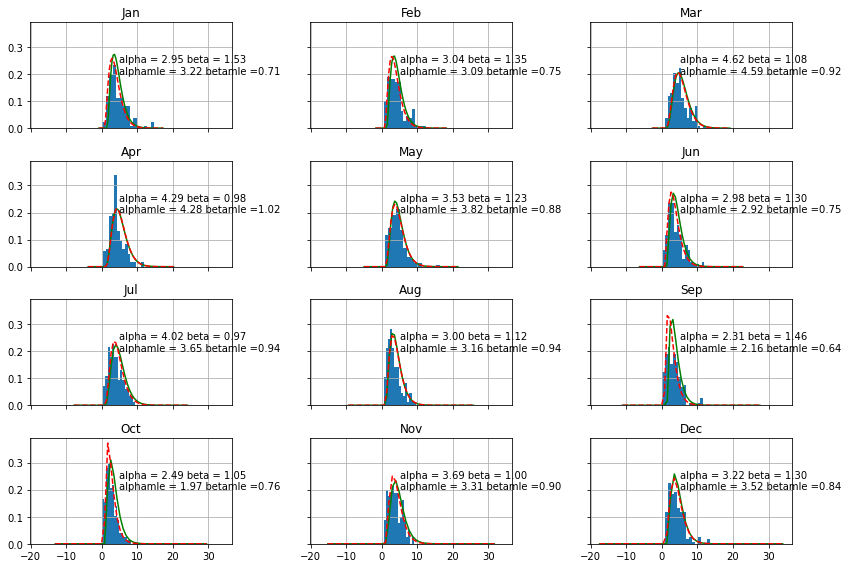

In [ ]:
from scipy.stats.distributions import gamma
axs = precip.hist(density=True, figsize=(12, 8), sharex=True, sharey=True, bins=15, grid=True)

for ax in axs.ravel():
    
    # Get month
    m = ax.get_title()
    
    # Plot fitted distribution
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, gamma.pdf(x, alpha_mom[m], beta_mom[m]),'g-')
    alpha_mle = newton(dlgamma,2, dl2gamma, args=(log_mean[m], mean_log[m]))
    beta_mle  = alpha_mle/precip.mean()[m]
    ax.plot(x, gamma.pdf(x, alpha_mle, beta_mle), 'r--')
    # Annotate with parameter estimates
    label = 'alpha = {0:.2f} beta = {1:.2f}\n'.format(alpha_mom[m], beta_mom[m])
    label1 = 'alphamle = {0:.2f} betamle ={1:.2f}'.format(alpha_mle, beta_mle)
    ax.annotate(label, xy=(5, 0.2))
    ax.annotate(label1, xy=(5, 0.2))
   
    
plt.tight_layout()

### Bayesian pymc3 metod

In [ ]:
from pymc3 import Model, Uniform, Normal

with Model() as Precip_model:
    α = Normal('α', 5, sd=2)
α

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


α ~ Normal

In [ ]:
with Precip_model:
    β = Uniform('β', lower=0, upper=10)
β

β ~ Uniform

In [ ]:
from pymc3 import Gamma
with Precip_model:
    Jan_like = Gamma("Jan_like", alpha=α, beta=β, observed=precip.Jan)

C:\Users\Thompson\AppData\Roaming\Python\Python39\site-packages\pymc3\distributions\continuous.py:138: UserWarning: The variable specified for alpha has negative support for Gamma, likely making it unsuitable for this parameter.
  warnings.warn(msg)


In [ ]:
from pymc3 import fit
RANDOM_SEED = 25000
with Precip_model: 
    Precip_trace = fit(random_seed=RANDOM_SEED).sample(100)

Finished [100%]: Average Loss = 357.68


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Thompson\AppData\Roaming\Python\Python39\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


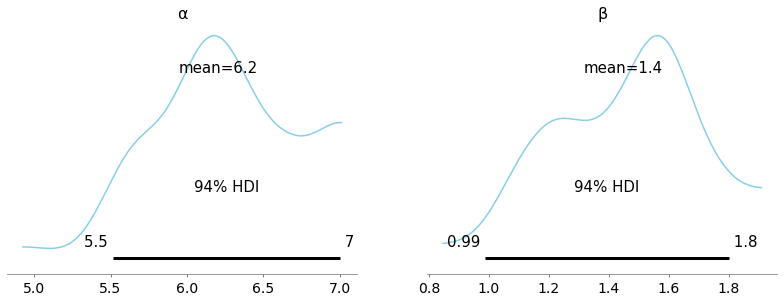

In [ ]:
from pymc3 import plot_posterior

plot_posterior(Precip_trace[0:], 
                var_names=['α', 'β'],
                color='#87ceeb');

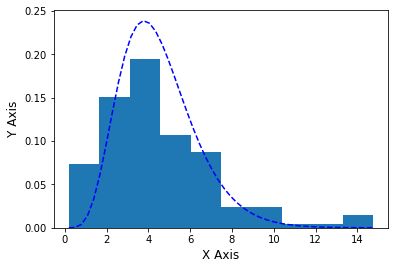

In [ ]:
from scipy.stats.distributions import gamma

Jan = precip.Jan
Jan.hist(density=True, bins=10, grid=False)
x = np.linspace(Jan.min(), Jan.max())
plt.ylabel('Y Axis', fontsize=12)
plt.xlabel('X Axis', fontsize=12)
plt.plot(x, gamma.pdf(x, 6.3, scale=1/1.4), 'b--')

# Feb

In [ ]:
from pymc3 import Model, Uniform, Normal, StudentT

with Model() as Feb_model:
    α = Normal('α', 5, sd=2)
with Feb_model:
    β = Uniform('β', lower=0, upper=10)
from pymc3 import Gamma
with Feb_model:
    Feb_like = Gamma("Feb_like", alpha=α, beta=β, observed=precip.Feb)

C:\Users\Thompson\AppData\Roaming\Python\Python39\site-packages\pymc3\distributions\continuous.py:138: UserWarning: The variable specified for alpha has negative support for Gamma, likely making it unsuitable for this parameter.
  warnings.warn(msg)


In [ ]:
from pymc3 import fit
RANDOM_SEED = 25000
with Feb_model: 
    Feb_trace = fit(random_seed=RANDOM_SEED).sample(100)

Finished [100%]: Average Loss = 345.07


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Thompson\AppData\Roaming\Python\Python39\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


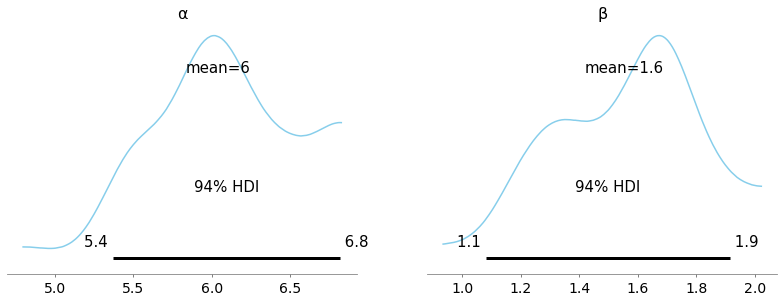

In [ ]:
from pymc3 import plot_posterior

plot_posterior(Feb_trace[0:], 
                var_names=['α', 'β'],
                color='#87ceeb');

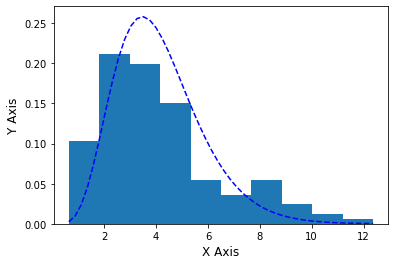

In [ ]:
from scipy.stats.distributions import gamma

Feb = precip.Feb
Feb.hist(density=True, bins=10, grid=False)
x = np.linspace(Feb.min(), Feb.max())
plt.ylabel('Y Axis', fontsize=12)
plt.xlabel('X Axis', fontsize=12)
plt.plot(x, gamma.pdf(x, 6.2, scale=1/1.5), 'b--')

# mar


In [ ]:
from pymc3 import Model, Uniform, Normal
from pymc3 import Gamma

with Model() as mar_model:
    
    malpha = Uniform('malpha', lower=0, upper=10)

with mar_model:
    mbeta = Normal('mbeta', 5, sd=2)
    

with mar_model:
    Mar_like = Gamma("Mar_like", alpha=malpha, beta=mbeta, observed=precip.Mar)


C:\Users\Thompson\AppData\Roaming\Python\Python39\site-packages\pymc3\distributions\continuous.py:138: UserWarning: The variable specified for beta has negative support for Gamma, likely making it unsuitable for this parameter.
  warnings.warn(msg)


In [ ]:
from pymc3 import fit
RANDOM_SEED = 25000
with mar_model: 
    mar_trace = fit(random_seed=RANDOM_SEED).sample(100)

Finished [100%]: Average Loss = 386.71


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Thompson\AppData\Roaming\Python\Python39\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


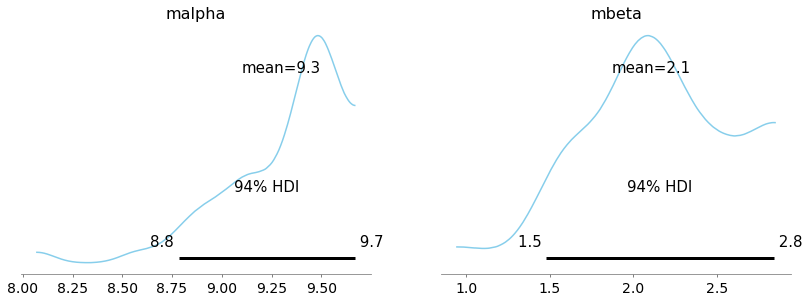

In [ ]:
from pymc3 import plot_posterior

plot_posterior(mar_trace[0:], 
                var_names=['malpha', 'mbeta'],
                color='#87ceeb');

# apr

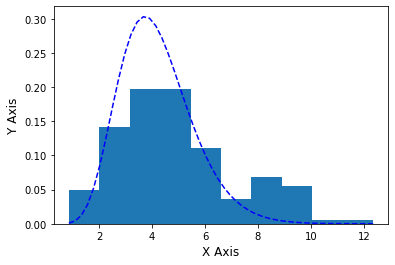

In [ ]:
from scipy.stats.distributions import gamma

mar = precip.Mar
mar.hist(density=True, bins=10, grid=False)
x = np.linspace(mar.min(), mar.max())
plt.ylabel('Y Axis', fontsize=12)
plt.xlabel('X Axis', fontsize=12)
plt.plot(x, gamma.pdf(x, 9.2, scale=1/2.2), 'b--')

In [ ]:
from pymc3 import Model, Uniform, Normal
from pymc3 import Gamma

with Model() as Apr_model:
    
    aalpha = Uniform('aalpha', lower=0, upper=10)

with Apr_model:
    abeta = Normal('abeta', 5, sd=2)
    

with Apr_model:
    Apr_like = Gamma("Apr_like", alpha=aalpha, beta=abeta, observed=precip.Apr)
    
from pymc3 import fit
RANDOM_SEED = 25000
with Apr_model: 
    Apr_trace = fit(random_seed=RANDOM_SEED).sample(100)

C:\Users\Thompson\AppData\Roaming\Python\Python39\site-packages\pymc3\distributions\continuous.py:138: UserWarning: The variable specified for beta has negative support for Gamma, likely making it unsuitable for this parameter.
  warnings.warn(msg)


Finished [100%]: Average Loss = 345.42


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Thompson\AppData\Roaming\Python\Python39\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


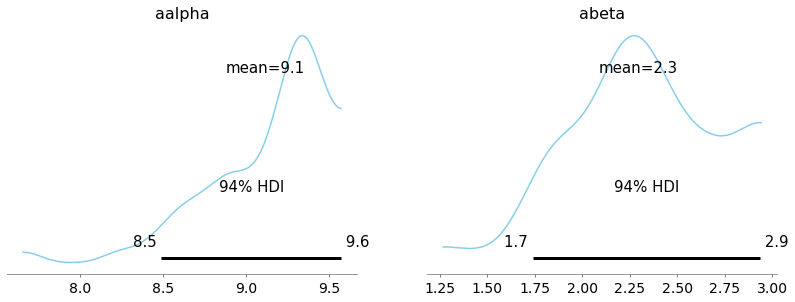

In [ ]:
from pymc3 import plot_posterior

plot_posterior(Apr_trace[0:], 
                var_names=['aalpha', 'abeta'],
                color='#87ceeb');

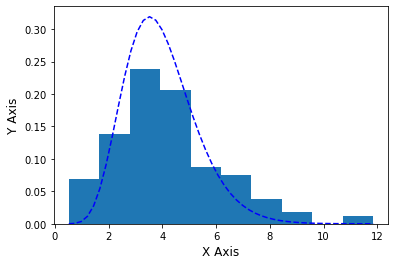

In [ ]:
from scipy.stats.distributions import gamma

apr = precip.Apr
apr.hist(density=True, bins=10, grid=False)
x = np.linspace(apr.min(), apr.max())
plt.ylabel('Y Axis', fontsize=12)
plt.xlabel('X Axis', fontsize=12)
plt.plot(x, gamma.pdf(x, 9.1, scale=1/2.3), 'b--')

# May

In [ ]:
from pymc3 import Model, Uniform, Normal, Exponential
from pymc3 import Gamma

with Model() as May_model:
    
    mayalpha = Exponential('mayalpha', 1/(10))

with May_model:
    maybeta =  Uniform('maybeta', lower=0, upper=10)
    

with May_model:
    may_like = Gamma("May_like", alpha=mayalpha, beta=maybeta, observed=precip.May)
    
from pymc3 import fit
RANDOM_SEED = 25000
with May_model: 
    May_trace = fit(random_seed=RANDOM_SEED).sample(100)

Finished [100%]: Average Loss = 396.8


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Thompson\AppData\Roaming\Python\Python39\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


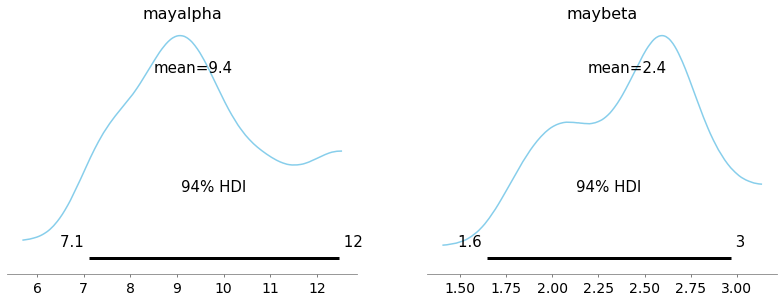

In [ ]:
from pymc3 import plot_posterior

plot_posterior(May_trace[0:], 
                var_names=['mayalpha', 'maybeta'],
                color='#87ceeb');

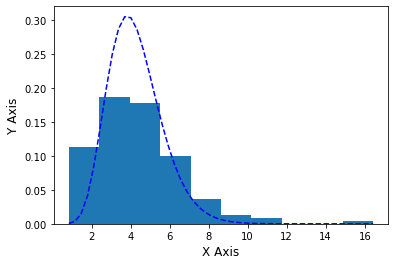

In [ ]:
from scipy.stats.distributions import gamma

May = precip.May
May.hist(density=True, bins=10, grid=False)
x = np.linspace(May.min(), May.max())
plt.ylabel('Y Axis', fontsize=12)
plt.xlabel('X Axis', fontsize=12)
plt.plot(x, gamma.pdf(x, 9.8, scale=1/2.3), 'b--')

# June

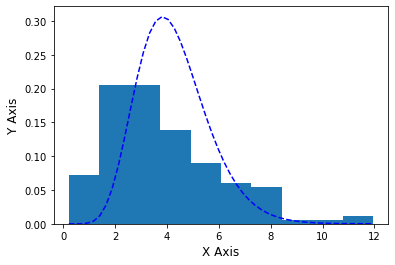

In [ ]:
from scipy.stats.distributions import gamma

june = precip.Jun
june.hist(density=True, bins=10, grid=False)
x = np.linspace(june.min(), june.max())
plt.ylabel('Y Axis', fontsize=12)
plt.xlabel('X Axis', fontsize=12)
plt.plot(x, gamma.pdf(x, 9.8, scale=1/2.3), 'b--')

In [ ]:
from pymc3 import Model, Uniform, Normal, Exponential
from pymc3 import Gamma

with Model() as June_model:
    
    Jalpha = Exponential('Jalpha', 1/(10))

with June_model:
    Jbeta = Normal('Jbeta', 4, sd=2)
    

with June_model:
    June_like = Gamma("June_like", alpha=Jalpha, beta=Jbeta, observed=precip.Jun)
    
from pymc3 import fit
RANDOM_SEED = 25000
with June_model: 
    June_trace = fit(random_seed=RANDOM_SEED).sample(100)

C:\Users\Thompson\AppData\Roaming\Python\Python39\site-packages\pymc3\distributions\continuous.py:138: UserWarning: The variable specified for beta has negative support for Gamma, likely making it unsuitable for this parameter.
  warnings.warn(msg)


Finished [100%]: Average Loss = 409.5


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Thompson\AppData\Roaming\Python\Python39\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


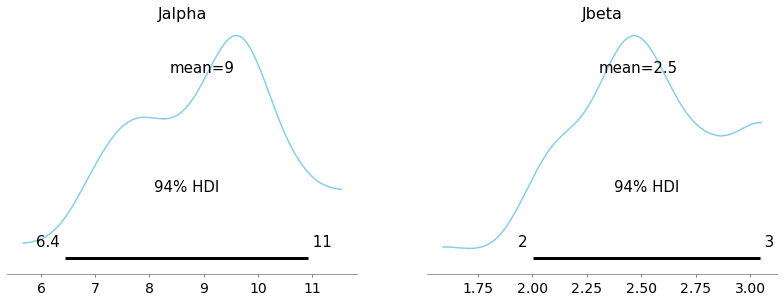

In [ ]:
from pymc3 import plot_posterior

plot_posterior(June_trace[0:], 
                var_names=['Jalpha', 'Jbeta'],
                color='#87ceeb');

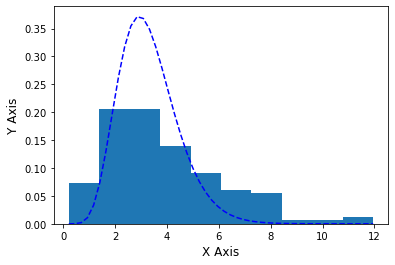

In [ ]:
from scipy.stats.distributions import gamma

June = precip.Jun
June.hist(density=True, bins=10, grid=False)
x = np.linspace(June.min(), June.max())
plt.ylabel('Y Axis', fontsize=12)
plt.xlabel('X Axis', fontsize=12)
plt.plot(x, gamma.pdf(x, 8.6, scale=1/2.6), 'b--')

# July

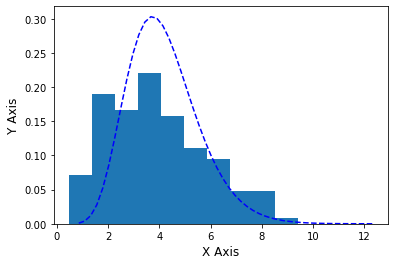

In [ ]:
from scipy.stats.distributions import gamma

july = precip.Jul
july.hist(density=True, bins=10, grid=False)
x = np.linspace(mar.min(), mar.max())
plt.ylabel('Y Axis', fontsize=12)
plt.xlabel('X Axis', fontsize=12)
plt.plot(x, gamma.pdf(x, 9.2, scale=1/2.2), 'b--')

In [ ]:
from pymc3 import Model, Uniform, Normal
from pymc3 import Gamma

with Model() as Jul_model:
    
    aalpha = Uniform('aalpha', lower=0, upper=10)

with Jul_model:
    abeta = Normal('abeta', 5, sd=2)
    

with Jul_model:
    jul_like = Gamma("jul_like", alpha=aalpha, beta=abeta, observed=precip.Apr)
    
from pymc3 import fit
RANDOM_SEED = 25000
with Jul_model: 
    jul_trace = fit(random_seed=RANDOM_SEED).sample(100)

Finished [100%]: Average Loss = 345.42


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Thompson\AppData\Roaming\Python\Python39\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


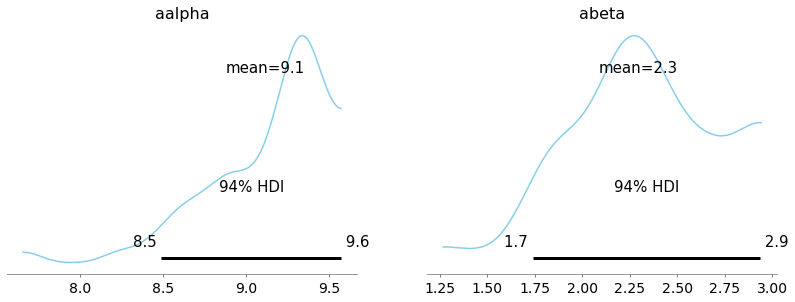

In [ ]:
from pymc3 import plot_posterior

plot_posterior(jul_trace[0:], 
                var_names=['aalpha', 'abeta'],
                color='#87ceeb');

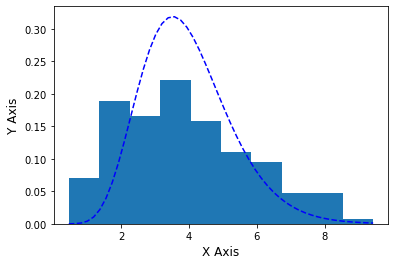

In [ ]:
from scipy.stats.distributions import gamma

apr = precip.Jul
apr.hist(density=True, bins=10, grid=False)
x = np.linspace(apr.min(), apr.max())
plt.ylabel('Y Axis', fontsize=12)
plt.xlabel('X Axis', fontsize=12)
plt.plot(x, gamma.pdf(x, 9.1, scale=1/2.3), 'b--')

### August

In [ ]:
from pymc3 import Model, Uniform, Normal, Exponential
from pymc3 import Gamma

with Model() as May_model:
    
    mayalpha = Exponential('mayalpha', 1/(10))

with May_model:
    maybeta =  Uniform('maybeta', lower=0, upper=10)
    

with May_model:
    may_like = Gamma("May_like", alpha=mayalpha, beta=maybeta, observed=precip.May)
    
from pymc3 import fit
RANDOM_SEED = 25000
with May_model: 
    May_trace = fit(random_seed=RANDOM_SEED).sample(100)

Finished [100%]: Average Loss = 396.8


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\Thompson\AppData\Roaming\Python\Python39\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


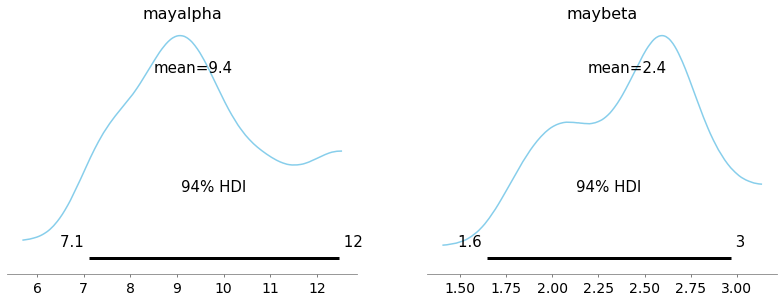

In [ ]:
from pymc3 import plot_posterior

plot_posterior(May_trace[0:], 
                var_names=['mayalpha', 'maybeta'],
                color='#87ceeb');

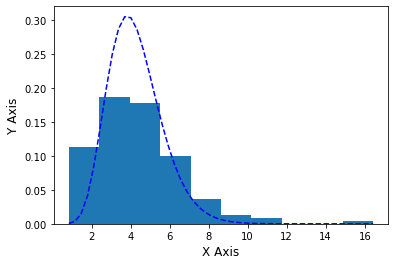

In [ ]:
from scipy.stats.distributions import gamma

May = precip.May
May.hist(density=True, bins=10, grid=False)
x = np.linspace(May.min(), May.max())
plt.ylabel('Y Axis', fontsize=12)
plt.xlabel('X Axis', fontsize=12)
plt.plot(x, gamma.pdf(x, 9.8, scale=1/2.3), 'b--')

September

In [ ]:
from pymc3 import  Model,Normal,Uniform,Gamma,sample
RANDOM_SEED = 2000095
with Model() as rainfall_model:
    sept_alpha = Normal('sept_alpha', 4, sd=3)
    sept_beta = Uniform('sept_beta', lower=0, upper=8)
    sept_like = Gamma('sept_like', sept_alpha, sept_beta, observed=precip.Sep)
    sept_trace = sample(1000)

In [ ]:
from pymc3 import plot_posterior
plot_posterior(sept_trace[100:], 
                var_names=['sept_alpha', 'sept_beta'],
                color='#87ceeb');

October

In [ ]:
from pymc3 import  Model,Normal,Uniform,Gamma,sample
RANDOM_SEED = 2008095
with Model() as rainfall_model:
    oct_alpha = Normal('oct_alpha', 4, sd=3)
    oct_beta = Uniform('oct_beta', lower=0, upper=8)
    oct_like = Gamma('oct_like', oct_alpha, oct_beta, observed=precip.Oct)
    oct_trace = sample(1000)

In [ ]:
from pymc3 import plot_posterior
plot_posterior(oct_trace[100:], 
                var_names=['oct_alpha', 'oct_beta'],
                color='#87ceeb');

November

In [ ]:
from pymc3 import  Model,Normal,Uniform,Gamma,sample
RANDOM_SEED = 2008095
with Model() as rainfall_model:
    nov_alpha = Normal('nov_alpha', 4, sd=3)
    nov_beta = Uniform('nov_beta', lower=0, upper=8)
    nov_like = Gamma('nov_like', nov_alpha, nov_beta, observed=precip.Nov)
    nov_trace = sample(1000)

In [ ]:
from pymc3 import plot_posterior
plot_posterior(oct_trace[100:], 
                var_names=['nov_alpha', 'nov_beta'],
                color='#87ceeb');

December

In [ ]:
from pymc3 import  Model,Normal,Uniform,Gamma,sample
RANDOM_SEED = 2008095
with Model() as rainfall_model:
    dec_alpha = Normal('dec_alpha', 4, sd=3)
    dec_beta = Uniform('dec_beta', lower=0, upper=8)
    dec_like = Gamma('dec_like', dec_alpha, dec_beta, observed=precip.Dec)
    dec_trace = sample(1000)

In [ ]:
from pymc3 import plot_posterior
plot_posterior(oct_trace[100:], 
                var_names=['dec_alpha', 'dec_beta'],
                color='#87ceeb');